In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from brainflow.data_filter import DataFilter, FilterTypes, DetrendOperations, WindowOperations
from sklearn.metrics import f1_score

In [2]:
class ToTensor(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        return {'window': torch.tensor(window.values).unsqueeze(0).to(torch.float32), 
                'labels': torch.tensor(labels).to(torch.float32)}#.values)}

class AbsoluteValue(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        return {'window': torch.abs(window), 
                'labels': labels}

class Normalize(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        return {'window': F.normalize(window), 
                'labels': labels}

class MinNormalize(object):
    def __call__(self, sample):
        window, labels = sample['window'], sample['labels']
        min = torch.min(window)
        window = window - min
        window = window / torch.max(window)
        return {'window': (window), 
                'labels': labels}

class EEGDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = pd.read_csv(csv_file, delimiter='\t', header=None)
        self.transform = transform
    
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        # if idx >= len(self.csv_file) / 1250:
        #     return

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        window = self.csv_file.iloc[idx*1250:idx*1250+1250, 7]
        labels = [self.csv_file.iloc[idx*1250, 32]]#:idx*1250+1250, 32] # remove brackets for timestep prediction
        sample = {'window': window, 'labels': labels}

        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [3]:
eeg_dataset = EEGDataset(csv_file='./pasteEOCTest.csv', transform=transforms.Compose([ToTensor(),
                                                                                  AbsoluteValue(),
                                                                                  MinNormalize()]))

kuba_dataset = EEGDataset(csv_file='./pasteEOCTest.csv', transform=transforms.Compose([ToTensor(),
                                                                                  AbsoluteValue(),
                                                                                  MinNormalize()]))

eeg_dataset = torch.utils.data.Subset(eeg_dataset, range(0, 48))
kuba_dataset = torch.utils.data.Subset(eeg_dataset, range(0, 48))

torch.manual_seed(50) # 80
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset, [0.6, 0.2, 0.2])

print(len(train_dataset), len(val_dataset), len(test_dataset))

zerocount = 0
onecount = 0

for i in range(len(train_dataset)):
    if train_dataset[i]['labels'][0] == 1:
        onecount += 1
    else:
        zerocount += 1

print(onecount, zerocount)

zerocount = 0
onecount = 0

for i in range(len(val_dataset)):
    if val_dataset[i]['labels'][0] == 1:
        onecount += 1
    else:
        zerocount += 1

print(onecount, zerocount)

zerocount = 0
onecount = 0

for i in range(len(test_dataset)):
    if test_dataset[i]['labels'][0] == 1:
        onecount += 1
    else:
        zerocount += 1

print(onecount, zerocount)

29 10 9
12 17
4 6
8 1


In [4]:
num_train = len(train_dataset)
window_tensors = torch.empty(size=(num_train, 1, 1250))
label_tensors = torch.empty(size=(num_train, 1))

for i in range(num_train):
    window_tensors[i] = train_dataset[i]['window']
    label_tensors[i] = train_dataset[i]['labels']

torch.save(window_tensors, 'window_tensors.pt')
torch.save(label_tensors, 'label_tensors.pt')

window_tensors = torch.load('window_tensors.pt')
label_tensors = torch.load('label_tensors.pt')

print(window_tensors.shape)
print(label_tensors.shape)

torch.Size([29, 1, 1250])
torch.Size([29, 1])


/var/folders/jy/pdjxhl6d6q58q0b7w0sk_g_80000gn/T/ipykernel_30959/2291086987.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  window_tensors = torch.load('window_tensors.

In [5]:
num_val = len(val_dataset)
val_window_tensors = torch.empty(size=(num_val, 1, 1250))
val_label_tensors = torch.empty(size=(num_val, 1))

for i in range(num_val):
    val_window_tensors[i] = val_dataset[i]['window']
    val_label_tensors[i] = val_dataset[i]['labels']

torch.save(val_window_tensors, 'val_window_tensors.pt')
torch.save(val_label_tensors, 'val_label_tensors.pt')

val_window_tensors = torch.load('val_window_tensors.pt')
val_label_tensors = torch.load('val_label_tensors.pt')

print(val_window_tensors.shape)
print(val_label_tensors.shape)

torch.Size([10, 1, 1250])
torch.Size([10, 1])


/var/folders/jy/pdjxhl6d6q58q0b7w0sk_g_80000gn/T/ipykernel_30959/622086804.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_window_tensors = torch.load('val_window_t

In [6]:
class EEGEyesOpenCloseClassifier(nn.Module):
    def __init__(self):
        super(EEGEyesOpenCloseClassifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, 5, stride=5)
        self.conv2 = nn.Conv1d(32, 64, 5, stride=5)
        self.pool1 = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        #print(x.shape)
        x = F.relu(x)
        x = self.pool1(x)
        #print(x.shape)
        x = x.squeeze(1)
        x = self.fc1(x)
        #print(x.shape)
        x = F.relu(x)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = F.sigmoid(x)
        return x


model = EEGEyesOpenCloseClassifier()
# model(torch.randn((1250,)).unsqueeze(0))

In [7]:
optimizer = torch.optim.SGD(model.parameters())
criterion = nn.BCELoss()

In [8]:
# lossi = []

# model.train()
# for epoch in tqdm(range(10000)):
#     optimizer.zero_grad()
#     y_pred = model(train_dataset[0]['window'])

#     # if epoch == 0:
#     #     print(y_pred)

#     loss = criterion(y_pred, train_dataset[0]['labels'])
#     lossi.append(loss.item())

#     loss.backward()
#     optimizer.step()
    
#     # if epoch <= 1:
#     #     for p in model.parameters():
#     #         print(p.grad)
    

# plt.plot(lossi)

# print(lossi)

In [9]:
losses = []
lossi = []
vallosses = []
vallossi = []

100%|██████████| 10000/10000 [07:59<00:00, 20.87it/s]


[np.float64(0.6866915965902394), np.float64(0.6864247815362339), np.float64(0.6861713775273027), np.float64(0.6859278637787392), np.float64(0.6857116263488243), np.float64(0.6855026236895857), np.float64(0.6852970760444115), np.float64(0.6850935549571596), np.float64(0.6848868748237347), np.float64(0.6846876062195877), np.float64(0.6844996645532805), np.float64(0.6843169619297159), np.float64(0.6841395435662105), np.float64(0.6839703239243606), np.float64(0.6837978959083557), np.float64(0.6836383301636269), np.float64(0.6834696798489012), np.float64(0.6833198707679222), np.float64(0.6831744436560006), np.float64(0.6830262685644215), np.float64(0.6828880556698503), np.float64(0.6827553736752477), np.float64(0.6826334698446865), np.float64(0.6825143982624186), np.float64(0.6823978382965614), np.float64(0.6822855534224674), np.float64(0.6821771613482771), np.float64(0.6820706663460567), np.float64(0.6819675482552627), np.float64(0.6818654413880973), np.float64(0.6817670032895845), np.floa

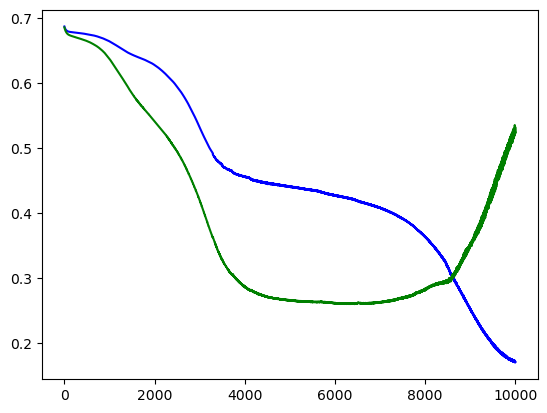

In [10]:
minValLoss = 9999

for epoch in tqdm(range(10000)):
    for i in range(len(window_tensors)):
        optimizer.zero_grad()
        model.train()
        y_pred = model(window_tensors[i])
        # print(y_pred)

        # if epoch == 0:
        #     print(y_pred)

        loss = criterion(y_pred, label_tensors[i])
        lossi.append(loss.item())
        loss.backward()
        optimizer.step()

        model.eval()
        for i in range(len(val_window_tensors)):
            val_pred = model(val_window_tensors[i])
            loss = criterion(val_pred, val_label_tensors[i])
            vallossi.append(loss.item())
        
        # if epoch <= 1:
        #     for p in model.parameters():
        #         print(p.grad)
    
    losses.append(np.mean(lossi))
    avgvalloss = np.mean(vallossi)
    if avgvalloss < minValLoss:
        minValLoss = avgvalloss
        torch.save(model.state_dict(), 'bestvalmodel.pt')
    vallosses.append(avgvalloss)
    if epoch % 100 == 0:
        plt.plot(losses, "b")
        plt.plot(vallosses, "g")
        plt.savefig('./valloss.png')
        plt.close()
    lossi = []
    vallossi = []
    

plt.plot(losses, "b")
plt.plot(vallosses, "g")

print(losses)

print(losses[-1])
torch.save(model.state_dict(), 'finaltrainmodel.pt')



In [11]:
minindex = torch.argmin(torch.tensor(vallosses))
print(losses[minindex], vallosses[minindex])

0.42029166995178396 0.25943196350869174


In [12]:
modelWeights = torch.load('./bestvalmodel.pt', weights_only=True)
#modelWeights = torch.load('./finaltrainmodel.pt', weights_only=True)
model = EEGEyesOpenCloseClassifier()
model.load_state_dict(modelWeights)
model.eval()
truepreds = 0
falsepreds = 0
truepositives = 0
falsepositives = 0
truenegatives = 0
falsenegatives = 0
preds = []
labels = []

with torch.no_grad():
    for i in range(len(kuba_dataset)):
        if i < 3:
            print(kuba_dataset[i]['window'])
        y_pred = model(kuba_dataset[i]['window'])
        # print(y_pred, kuba_dataset[i]['labels'])
        pred = (y_pred >= 0.5)
        preds.append(pred)
        label = kuba_dataset[i]['labels']
        labels.append(label)
        if pred == label:
            truepreds += 1
            if pred == 1:
                truepositives += 1
            else:
                truenegatives += 1
        else:
            falsepreds += 1
            if pred == 1:
                falsepositives += 1
            else:
                falsenegatives += 1

print(truepreds / (truepreds + falsepreds))
print(truepositives, truenegatives, falsepositives, falsenegatives)

f1Score = 2 * truepositives / (2 * truepositives + falsepositives + falsenegatives)
print(f1Score)

f1ScoreSKL = f1_score(labels, preds)
print(f1ScoreSKL)
        

tensor([[0.9007, 0.1634, 0.7920,  ..., 0.9640, 0.0171, 0.9272]])
tensor([[0.0738, 0.8790, 0.1523,  ..., 0.0145, 0.9952, 0.0201]])
tensor([[0.9731, 0.0559, 0.9212,  ..., 0.9895, 0.0095, 0.9876]])
0.8333333333333334
20 20 4 4
0.8333333333333334
0.8333333333333334


In [13]:
print((eeg_dataset[0]['window']))
#print(torch.min((no_normalize[0]['window'] - torch.min(no_normalize[0]['window']))/(torch.max(no_normalize[0]['window']))))

tensor([[0.9007, 0.1634, 0.7920,  ..., 0.9640, 0.0171, 0.9272]])


In [14]:
# torch.save(model, 'oct7model.pt')